In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
lbfgs_lr = 0.001
adam_lr = 0.001

w_pde = 1.0
w_bc = 1.0
w_ic = 1.0

In [26]:
class PINN():
    def __init__(self, x, t, int_vec, layers, f, ic1, ic2, train_cond='pde'):
        
        self.cond = train_cond

        self.x = x
        self.t = t

        self.int_d = int_vec[0]
        self.int_lbc = int_vec[1]
        self.int_rbc = int_vec[2]
        self.int_ic = int_vec[3]

        self.f = f
        self.ic1 = ic1
        self.ic2 = ic2

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=1000, gamma=0.5)
        self.iter = 0

    def model_value(self, x, t):
        out = self.dnn(torch.cat((x, t), dim=1))
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def space_derivative(self, u, m, x):
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]      

        return u_x, u_2x, m_x, m_2x
    
    def time_derivative(self, u , t):
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]
        return u_t, u_2t

    def bc_loss(self, u, m):
        bc_loss = torch.mean(u**2) + torch.mean(m**2)
        return bc_loss
    
    def ic_loss(self, u, u_t):
        ic_loss = torch.mean((u - self.ic1)**2)
        ic_loss += torch.mean((u_t - self.ic2)**2)
        return ic_loss

    def pde_loss(self, m_2x, u_2t):        
        pde_loss = torch.mean((u_2t + m_2x - self.f)**2)
        return pde_loss

    def loss_func(self):
        u, m = self.model_value(self.x, self.t)
        _, _, _, m_2x = self.space_derivative(u, m, self.x)
        u_t, u_2t = self.time_derivative(u, self.t)
        ic_loss = 0
        bc_loss = 0
        pde_loss = 0

        match self.cond:
            case 'ic':
                ic_loss += self.ic_loss(u[self.int_rbc:self.int_ic], u_t[self.int_rbc:self.int_ic])
            case 'bc':
                bc_loss += self.bc_loss(u[self.int_d:self.int_lbc], m[self.int_d:self.int_lbc])
                bc_loss += self.bc_loss(u[self.int_lbc:self.int_rbc], m[self.int_lbc:self.int_rbc])
            case 'pde':
                pde_loss += self.pde_loss(m_2x[:self.int_d], u_2t[:self.int_d])
                bc_loss += self.bc_loss(u[self.int_d:self.int_lbc], m[self.int_d:self.int_lbc])
                bc_loss += self.bc_loss(u[self.int_lbc:self.int_rbc], m[self.int_lbc:self.int_rbc])
                ic_loss += self.ic_loss(u[self.int_rbc:self.int_ic], u_t[self.int_rbc:self.int_ic])  
        return w_pde*pde_loss + w_bc*bc_loss + w_ic*ic_loss


    def lbfgs_func(self):
        loss = self.loss_func()
        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        print(self.cond)
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func()

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()
            # self.scheduler.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, x, t):
        x = torch.tensor(x).float().to(device)
        t = torch.tensor(t).float().to(device)

        self.dnn.eval()
        u, _ = self.model_value(x, t)
        u = u.detach().cpu().numpy()
        return u

In [27]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

In [28]:
def generate_points(points):
    def ic_points(n_points):
        x = torch.rand(n_points, device=device) * torch.pi
        t = torch.zeros(n_points, device=device)
        return x, t

    def bc_points(n_points, x_bc):
        x = torch.ones(n_points, device=device) * x_bc
        t = torch.rand(n_points, device=device)
        return x, t

    def domain_points(n_points):
        x = torch.rand(n_points, device=device) * torch.pi
        t = torch.rand(n_points, device=device)
        return x, t

    x_d, t_d = domain_points(points[0])
    x_bc_lb, t_bc_lb = bc_points(points[1], 0)
    x_bc_rb, t_bc_rb = bc_points(points[1], torch.pi)
    x_ic, t_ic = ic_points(points[2])

    x_all = torch.cat([x_d, x_bc_lb, x_bc_rb, x_ic], dim=0).view(-1, 1)
    t_all = torch.cat([t_d, t_bc_lb, t_bc_rb, t_ic], dim=0).view(-1, 1)

    int1 = points[0]
    int2 = int1 + points[1]
    int3 = int2 + points[1]
    int4 = int3 + points[2]
    
    return x_all, t_all, [int1, int2, int3, int4]

In [29]:
points = [10000, 2000, 2000]
x_t, t_t, int_vec = generate_points(points)


x_ic = x_t[int_vec[2]:int_vec[3]]
x_d = x_t[:int_vec[0]]
t_d = t_t[:int_vec[0]]

f = lambda x, t: (1 - 16*torch.pi**2)*torch.sin(x)*torch.cos(4*torch.pi*t)
ic1 = lambda x: torch.sin(x)
ic2 = lambda x: torch.full_like(x, 0)

vec1 = ic1(x_ic)
vec2 = ic2(x_ic)
fun = f(x_d, t_d)

x_t = x_t.requires_grad_()
t_t = t_t.requires_grad_()


In [30]:
nodes = 64
layers = [2, nodes, nodes, nodes, nodes, 2]

model = PINN(x_t, t_t, int_vec, layers, fun, vec1, vec2)

In [ ]:
model.cond = 'ic'
model.train(3000)

In [49]:
model.cond = 'pde'
model.train(3000)

pde
Epoch 0, Loss: 3.213889e-02
Epoch 100, Loss: 3.766957e-02
Epoch 200, Loss: 3.244006e-02
Epoch 300, Loss: 3.099365e-02
Epoch 400, Loss: 4.054387e-02
Epoch 500, Loss: 3.248870e-02
Epoch 600, Loss: 3.070354e-02
Epoch 700, Loss: 1.359612e-01
Epoch 800, Loss: 3.169879e-02
Epoch 900, Loss: 2.983764e-02
Epoch 1000, Loss: 7.249468e-02
Epoch 1100, Loss: 3.213572e-02
Epoch 1200, Loss: 2.993071e-02
Epoch 1300, Loss: 2.845863e-02
Epoch 1400, Loss: 5.962503e-02
Epoch 1500, Loss: 3.667006e-02
Epoch 1600, Loss: 3.281663e-02
Epoch 1700, Loss: 3.064237e-02
Epoch 1800, Loss: 2.905742e-02
Epoch 1900, Loss: 2.779120e-02
Epoch 2000, Loss: 4.336110e-02
Epoch 2100, Loss: 2.872128e-02
Epoch 2200, Loss: 2.738190e-02
Epoch 2300, Loss: 3.331370e-02
Epoch 2400, Loss: 2.812393e-02
Epoch 2500, Loss: 2.718338e-02
Epoch 2600, Loss: 4.145785e-02
Epoch 2700, Loss: 2.815787e-02
Epoch 2800, Loss: 8.525323e+00
Epoch 2900, Loss: 2.959379e-02


In [52]:
torch.save(model.dnn.state_dict(), "time_model_weights.pth")

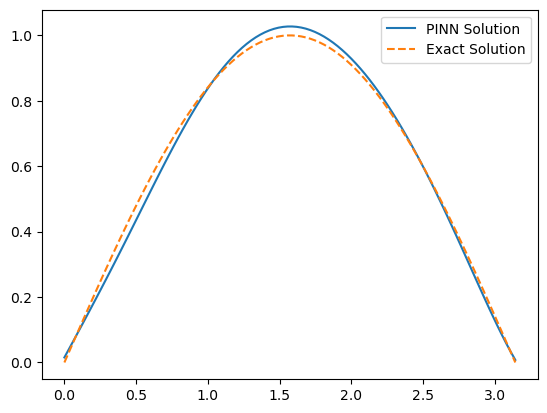

In [50]:

x = np.linspace(0, torch.pi, 100).reshape(-1, 1)
t = np.zeros(100).reshape(-1, 1)

y = np.sin(x)

u = model.predict(x, t)
plt.plot(x, u, label="PINN Solution")
plt.plot(x, y, label="Exact Solution", linestyle="dashed")
plt.legend()

0.2535648704224431


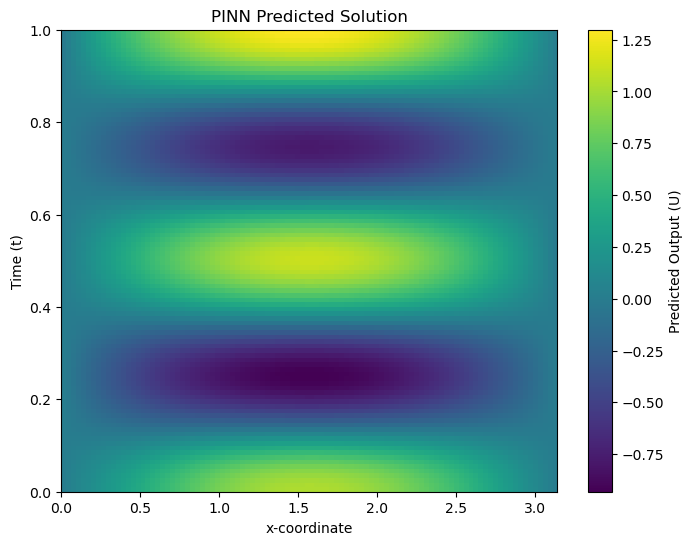

In [51]:
# Define the resolution of the grid
x_min, x_max = 0, np.pi  # X range
t_min, t_max = 0, 1  # Time range
grid_size = 100  # Number of points in each dimension

# Create a meshgrid
x_vals = np.linspace(x_min, x_max, grid_size)
t_vals = np.linspace(t_min, t_max, grid_size)
X, T = np.meshgrid(x_vals, t_vals)  # Create a 2D meshgrid

# Flatten the meshgrid and convert to PyTorch tensor
X_flat = X.flatten().reshape(-1, 1)
T_flat = T.flatten().reshape(-1, 1)

u_exact = np.sin(X_flat) * np.cos(4 * torch.pi * T_flat)
u_pred = model.predict(X_flat, T_flat)

abs_error = np.abs(u_pred - u_exact)
l2_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact, 2)

u_pred = u_pred.reshape(grid_size, grid_size)
u_exact = u_exact.reshape(grid_size, grid_size)
abs_error = abs_error.reshape(grid_size, grid_size)

print(l2_error)

# Plot the result with correct axis scaling
plt.figure(figsize=(8, 6))
plt.imshow(u_pred, extent=[x_min, x_max, t_min, t_max], origin="lower", aspect="auto")
plt.colorbar(label="Predicted Output (U)")
plt.xlabel("x-coordinate")
plt.ylabel("Time (t)")
plt.title("PINN Predicted Solution")
plt.show()